In [5]:
# 10 class
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torchvision
import numpy as np
from torch.utils.data import Subset
from moe import MOE_LeNET_ResNet
device=torch.device("cuda:7" if torch.cuda.is_available() else "cpu")


In [6]:
import argparse
import argparse
import sys

# 检查并移除 Jupyter 传递的参数
if any('--f=' in arg for arg in sys.argv):
    # 移除包含 '--f=' 的所有参数
    sys.argv = [arg for arg in sys.argv if not arg.startswith('--f=')]
def parse_args():
    parser = argparse.ArgumentParser(description="Train a Mixture-of-Experts model.")
    parser.add_argument("--smooth_steps",type=int,default=20,help="number of steps for smooth mode")
    parser.add_argument("--smooth_lb",type=int,default=900,help="number lower bound of steps for smooth mode")
    parser.add_argument("--seed",type=int,default=123) #1234
    return parser.parse_args()
args=parse_args()
torch.manual_seed(args.seed)

In [7]:
input_size,num_experts,hidden_size,depth,output_size=784,2,512,2,10
MoE= MOE_LeNET_ResNet(input_size, num_experts, hidden_size, depth, output_size,k=2,loss_coef=1).to(device)

=== Trainable parameters ===
Total trainable params: 271954



In [9]:

criterion = nn.CrossEntropyLoss()
epochs = 200

# 优化器不变
optimizer = torch.optim.SGD(MoE.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)

# 使用 CosineAnnealingLR，T_max 设置为总训练周期
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)



CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)
train_transform = transforms.Compose([
    # 1. 随机裁剪 (RandomCrop):
    #   将图像填充 4 像素 (变成 40x40)，然后随机裁剪回 32x32。
    #   这创造了视觉上的平移变化，迫使模型关注图像的不同部分。
    transforms.RandomCrop(32, padding=4),
    
    # 2. 随机水平翻转 (RandomHorizontalFlip):
    #   以 50% 的概率水平翻转图像。这有助于模型学习旋转不变性。
    transforms.RandomHorizontalFlip(),
    
    # 3. 转换为张量
    transforms.ToTensor(),
    
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# --- 2. 测试集数据预处理 (Test Transforms) ---
# 测试集不需要增强，只需要转换为张量和标准化，以保证评估的公正性。
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

batch_size = 50
trainset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/home/zhy/Zhou/mixture_of_experts/_image_run/CIFAR10/', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    running_aux_loss = 0.0
    step_count=args.smooth_steps
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        
        
        step_count -=1
        if MoE.moe.smooth and step_count<=0:
            MoE.moe.smoothing(i,args.smooth_lb)
            step_count=args.smooth_steps
        elif step_count<=0 :
            MoE.moe.smoothing(i,args.smooth_lb)
            step_count=args.smooth_steps

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux_loss= MoE(inputs)
        loss = criterion(outputs, labels)
        total_loss =loss+ aux_loss
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_aux_loss += aux_loss.item()
        if i % 190== 189:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 190:.3f}, aux_loss: {running_aux_loss/190:.3f}')
            running_loss = 0.0
            running_aux_loss = 0.0
        scheduler.step()

print('Finished Training')

[1,   190] loss: 2.611, aux_loss: 0.081
[1,   380] loss: 2.594, aux_loss: 0.032
[1,   570] loss: 2.589, aux_loss: 0.073
[1,   760] loss: 2.565, aux_loss: 0.051
[1,   950] loss: 2.576, aux_loss: 0.101
[2,   190] loss: 2.572, aux_loss: 0.104
[2,   380] loss: 2.561, aux_loss: 0.125
[2,   570] loss: 2.547, aux_loss: 0.146
[2,   760] loss: 2.554, aux_loss: 0.114
[2,   950] loss: 2.547, aux_loss: 0.098
[3,   190] loss: 2.546, aux_loss: 0.109
[3,   380] loss: 2.541, aux_loss: 0.138
[3,   570] loss: 2.543, aux_loss: 0.095
[3,   760] loss: 2.535, aux_loss: 0.090
[3,   950] loss: 2.535, aux_loss: 0.153
[4,   190] loss: 2.531, aux_loss: 0.177
[4,   380] loss: 2.544, aux_loss: 0.167
[4,   570] loss: 2.525, aux_loss: 0.159
[4,   760] loss: 2.532, aux_loss: 0.149
[4,   950] loss: 2.516, aux_loss: 0.100
[5,   190] loss: 2.520, aux_loss: 0.136
[5,   380] loss: 2.519, aux_loss: 0.126
[5,   570] loss: 2.535, aux_loss: 0.124
[5,   760] loss: 2.515, aux_loss: 0.141
[5,   950] loss: 2.526, aux_loss: 0.144


In [13]:
Path =f"/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/_cifar10_moe.pt"
torch.save(MoE.state_dict(), Path)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


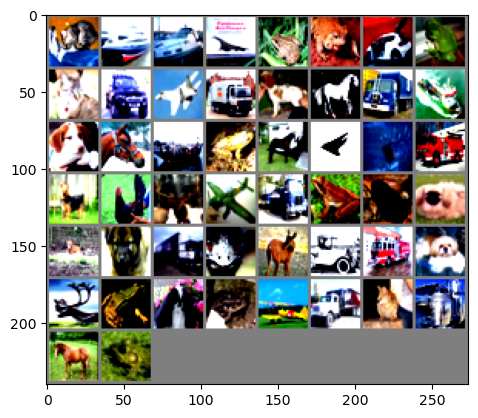

GroundTruth:  cat   ship  ship  plane


In [14]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [15]:
net =MOE_LeNET_ResNet(input_size, num_experts, hidden_size, depth, output_size,k=2,loss_coef=1e-2)
Path= f"/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/_cifar10_moe.pt"
net.load_state_dict(torch.load(Path, weights_only=True))
outputs,_= net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))


correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs,_ = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

=== Trainable parameters ===
Total trainable params: 271954

Predicted:  cat   frog  dog   dog  


Accuracy of the network on the 10000 test images: 17 %


In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs,_ = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 0.0 %
Accuracy for class: car   is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 70.9 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 81.4 %
Accuracy for class: frog  is 11.2 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 16.1 %
Accuracy for class: truck is 0.0 %
